<a href="https://colab.research.google.com/github/OlegPozovnoy/RLHW3/blob/master/10_gan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import torchvision.datasets as datasets
from torchvision.utils import make_grid

## Pix2Pix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def plot_losses(d_losses, g_losses):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)

    n_epochs = len(d_losses) - 1
    x_train = np.linspace(0, n_epochs, len(d_losses))
    x_test = np.arange(n_epochs + 1)

    ax.plot(x_train, d_losses, label='Ошибка дискриминатора')
    ax.plot(x_test, g_losses, label='Ошибка генератора')
    ax.legend()
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.show()

In [5]:

class ConvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out


class DeconvBlock(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True):
        super(DeconvBlock, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size,
                                               kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.25)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        return out


class Generator(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()


        self.conv1 = ConvBlock(input_dim, 64, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512)
        self.conv5 = ConvBlock(512, 512, batch_norm=False)

        self.deconv1 = DeconvBlock(512, 512)
        self.deconv2 = DeconvBlock(1024, 256)
        self.deconv3 = DeconvBlock(512, 128)
        self.deconv4 = DeconvBlock(256, 64)
        self.deconv5 = DeconvBlock(128, output_dim, batch_norm=False)

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)

        dec1 = self.deconv1(enc5)
        dec1 = torch.cat([dec1, enc4], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc3], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc2], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc1], 1)
        dec5 = self.deconv5(dec4)
        out = torch.nn.Tanh()(dec5)
        return out


class Discriminator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, 64, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512, stride=1)
        self.conv5 = ConvBlock(512, 1, stride=1, batch_norm=False)

    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)




In [7]:
import torch.utils.data as data
import os
from PIL import Image

class loadData(data.Dataset):
    def __init__(self, image_dir, subfolder, transform):
        super(loadData, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.transform = transform

    def __getitem__(self, index):
        fileim = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(fileim)
        
        image = img.crop((0, 0, img.width // 2, img.height))
        templ = img.crop((img.width // 2, 0, img.width, img.height))
        
        image = self.transform(image)
        templ = self.transform(templ)

        return templ, image

    def __len__(self):
        return len(self.image_filenames)

In [8]:
from torchvision.utils import save_image


batch_size = 64

transform = transforms.Compose([
                  transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

path_to_data = '/content/drive/MyDrive/datasets/facades/'

train_data = loadData(path_to_data, 'train', transform)

train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=batch_size,
                                                shuffle=True)

test_data = loadData(path_to_data, 'test', transform)
test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=batch_size,
                                               shuffle=False)


G = Generator(3, 3)
D = Discriminator(6)
G.cuda()
D.cuda()

BCE_loss = torch.nn.BCELoss().cuda()
L1_loss = torch.nn.L1Loss().cuda()

lr, beta1, beta2 = 0.0002, 0.5, 0.999
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

batches_done = 0

num_epochs = 300

D_losses = []
G_losses = []

for epoch in range(num_epochs):


    for i, (input, target) in enumerate(train_data_loader):

        x_ = Variable(input.cuda())
        y_ = Variable(target.cuda())

        # подаем реальные данные
        D_real = D(x_, y_).squeeze()
        real_ = Variable(torch.ones(D_real.size()).cuda())
        D_real_loss = BCE_loss(D_real, real_)

        # подаем сгенерированные данные
        gen_image = G(x_)
        D_fake = D(x_, gen_image).squeeze()
        fake_ = Variable(torch.zeros(D_fake.size()).cuda())
        D_fake_loss = BCE_loss(D_fake, fake_)

        # пропагиируем дискриминатор
        D_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # тренеруем генератор
        gen_image = G(x_)
        D_fake_decision = D(x_, gen_image).squeeze()
        G_fake_loss = BCE_loss(D_fake_decision, real_)

        l1_loss = 100 * L1_loss(gen_image, y_)

        # пропагиируем генератор
        G_loss = G_fake_loss + l1_loss
        G.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        D_losses.append(D_loss.data.item())
        G_losses.append(G_loss.data.item())
        print("\t...epoch %d/%d\tbatch %d/%d\tD loss: %.6f\tG loss: %.6f" % \
                      (epoch, num_epochs, i, len(train_data_loader),  D_loss.data.item(), G_loss.data.item()))

        batches_done += 1

        if batches_done % 100 == 0:
                gen_imgs = G(x_)
                gen_imgs = gen_image.cpu().data
                save_image(gen_imgs.data[:5], "%s/%05d.png" % (path_to_data + "/out/", batches_done), nrow=5, normalize=True)

    plot_losses(D_losses,G_losses )





KeyboardInterrupt: ignored

In [11]:
for i, (input, target) in enumerate(test_data_loader):
          gen_imgs = G(x_)
          gen_imgs = gen_image.cpu().data
          save_image(gen_imgs.data[:], "%s/%05d.png" % (path_to_data + "/result/", batches_done), nrow=500, normalize=True)


## CycleGAN

In [9]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        self.conv1 = ConvBlock(input_dim, 64, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(64, 128)
        self.conv3 = ConvBlock(128, 256)
        self.conv4 = ConvBlock(256, 512, stride=1)
        self.conv5 = ConvBlock(512, 1, stride=1, batch_norm=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        out = torch.nn.Sigmoid()(x)
        return out

    def normal_weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, ConvBlock):
                torch.nn.init.normal(m.conv.weight, mean, std)


In [10]:
from torchsummary import summary

In [15]:
summary(Discriminator(3).cuda(),(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         ConvBlock-2         [-1, 64, 128, 128]               0
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,200
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         ConvBlock-6          [-1, 128, 64, 64]               0
         LeakyReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,544
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        ConvBlock-10          [-1, 256, 32, 32]               0
        LeakyReLU-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 31, 31]       2,097,664
      BatchNorm2d-13          [-1, 512, 31, 31]           1,024
        ConvBlock-14          [-1, 512,

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([32, 30, 30])) that is different to the input size (torch.Size([32, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	...epoch 0/300	batch 0/13	D loss: 1.034760	G loss: 22.630840
	...epoch 0/300	batch 1/13	D loss: 1.082341	G loss: 20.027229
	...epoch 0/300	batch 2/13	D loss: 1.045222	G loss: 16.964413
	...epoch 0/300	batch 3/13	D loss: 1.068755	G loss: 15.188247
	...epoch 0/300	batch 4/13	D loss: 0.899968	G loss: 13.520003
	...epoch 0/300	batch 5/13	D loss: 0.868046	G loss: 12.069539
	...epoch 0/300	batch 6/13	D loss: 0.850224	G loss: 11.305090
	...epoch 0/300	batch 7/13	D loss: 0.805699	G loss: 10.461935
	...epoch 0/300	batch 8/13	D loss: 0.698943	G loss: 9.614551
	...epoch 0/300	batch 9/13	D loss: 0.664892	G loss: 9.204029
	...epoch 0/300	batch 10/13	D loss: 0.611353	G loss: 8.751176
	...epoch 0/300	batch 11/13	D loss: 0.595284	G loss: 8.433352


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([16, 30, 30])) that is different to the input size (torch.Size([16, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	...epoch 0/300	batch 12/13	D loss: 0.573691	G loss: 8.092567


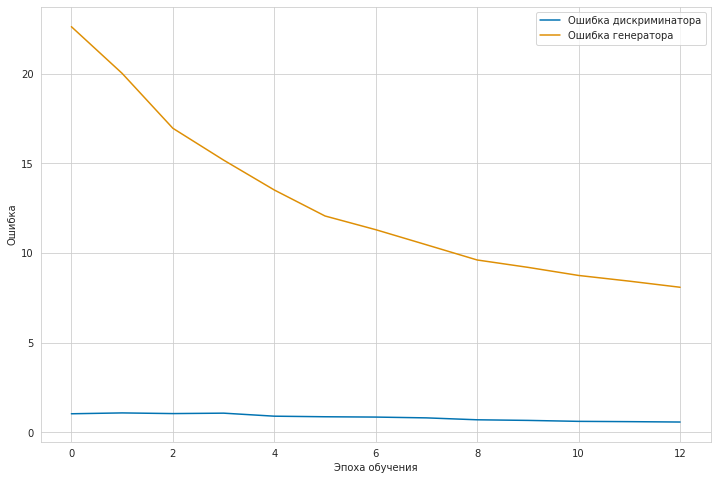

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([32, 30, 30])) that is different to the input size (torch.Size([32, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	...epoch 1/300	batch 0/13	D loss: 0.785163	G loss: 8.278779
	...epoch 1/300	batch 1/13	D loss: 0.648598	G loss: 7.554331
	...epoch 1/300	batch 2/13	D loss: 0.556718	G loss: 7.569345
	...epoch 1/300	batch 3/13	D loss: 0.483564	G loss: 7.736037
	...epoch 1/300	batch 4/13	D loss: 0.450801	G loss: 7.677318
	...epoch 1/300	batch 5/13	D loss: 0.394225	G loss: 7.172006
	...epoch 1/300	batch 6/13	D loss: 0.361804	G loss: 6.973363
	...epoch 1/300	batch 7/13	D loss: 0.354479	G loss: 6.844457
	...epoch 1/300	batch 8/13	D loss: 0.322702	G loss: 6.781717
	...epoch 1/300	batch 9/13	D loss: 0.347300	G loss: 6.542488
	...epoch 1/300	batch 10/13	D loss: 0.389556	G loss: 6.446992
	...epoch 1/300	batch 11/13	D loss: 0.305301	G loss: 6.482200


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([16, 30, 30])) that is different to the input size (torch.Size([16, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	...epoch 1/300	batch 12/13	D loss: 0.299364	G loss: 6.194046


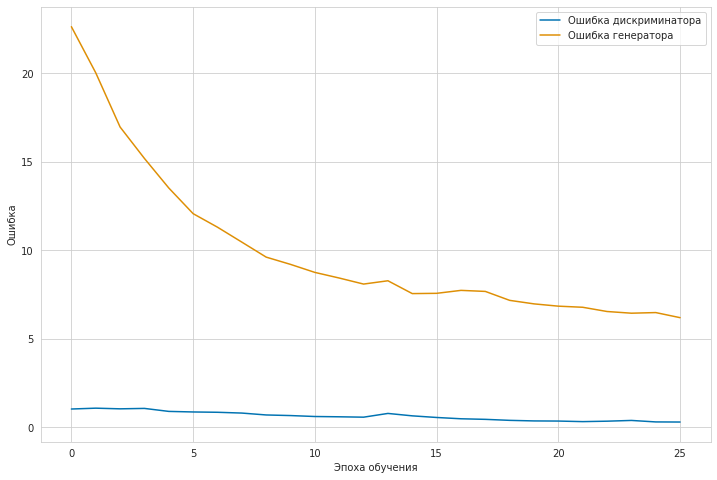

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([32, 30, 30])) that is different to the input size (torch.Size([32, 1, 30, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	...epoch 2/300	batch 0/13	D loss: 0.310408	G loss: 6.327644
	...epoch 2/300	batch 1/13	D loss: 0.305302	G loss: 6.171597
	...epoch 2/300	batch 2/13	D loss: 0.298783	G loss: 6.108186
	...epoch 2/300	batch 3/13	D loss: 0.279709	G loss: 6.031372
	...epoch 2/300	batch 4/13	D loss: 0.456897	G loss: 5.697209
	...epoch 2/300	batch 5/13	D loss: 0.540158	G loss: 6.060191
	...epoch 2/300	batch 6/13	D loss: 0.523128	G loss: 5.805799


In [ ]:

from torchvision.utils import save_image
import itertools

batch_size = 32

transform = transforms.Compose([
                  transforms.ToTensor(),
                 transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

path_to_data = '/content/drive/MyDrive/datasets/facades/'

train_data = loadData(path_to_data, 'train', transform)

train_data_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                batch_size=batch_size,
                                                shuffle=True)

test_data = loadData(path_to_data, 'test', transform)
test_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=batch_size,
                                               shuffle=False)


GA2B = Generator(3, 3)
DA = Discriminator(3)
GB2A = Generator(3, 3)
DB = Discriminator(3)

GA2B.cuda()
DA.cuda()
GB2A.cuda()
DB.cuda()

cycle_loss = torch.nn.L1Loss().cuda()
identity_loss = torch.nn.L1Loss().cuda()
adversarial_loss = torch.nn.MSELoss().cuda()

identity_losses = []
gan_losses = []
cycle_losses = []

lr, beta1, beta2 = 0.0002, 0.5, 0.999

G_optimizer = torch.optim.Adam(itertools.chain(GA2B.parameters(), 
                GB2A.parameters()), lr=lr, betas=(beta1, beta2))

DA_optimizer = torch.optim.Adam(DA.parameters(), lr=lr, betas=(beta1, beta2))
DB_optimizer = torch.optim.Adam(DB.parameters(), lr=lr, betas=(beta1, beta2))

batches_done = 0

num_epochs = 300
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    for i, (input, target) in enumerate(train_data_loader):

        A_ = Variable(input.cuda())
        B_ = Variable(target.cuda())

        real_ = Variable(torch.ones(DA(A_).squeeze().size()).cuda())
        fake_ = Variable(torch.zeros(DA(A_).squeeze().size()).cuda())

        G_optimizer.zero_grad()
        # identity loss
        identity_image_A = GB2A(A_)
        loss_identity_A = identity_loss(identity_image_A, A_) * 5.0

        identity_image_B = GA2B(B_)
        loss_identity_B = identity_loss(identity_image_B, B_) * 5.0

        # GAN loss
        fake_A = GB2A(B_)
        fake_output_A = DA(fake_A)
        loss_GAN_B2A = adversarial_loss(fake_output_A, real_)

        fake_B = GA2B(A_)
        fake_output_B = DB(fake_B)
        loss_GAN_A2B = adversarial_loss(fake_output_B, real_)

        # Cycle loss
        recovered_A = GB2A(fake_B)
        loss_cycle_ABA = cycle_loss(recovered_A, A_) * 10.0

        recovered_B = GA2B(fake_A)
        loss_cycle_BAB = cycle_loss(recovered_B, B_) * 10.0

        errG = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        errG.backward()


        G_optimizer.step()

        # DA discr
        DA_optimizer.zero_grad()

        real_output_A = DA(A_)
        errD_real_A = adversarial_loss(real_output_A, real_)

        fake_output_A = DA(fake_A.detach())
        errD_fake_A = adversarial_loss(fake_output_A, fake_)

        errD_A = errD_real_A + errD_fake_A

        errD_A.backward()
        DA_optimizer.step()

        # DB discr
        DB_optimizer.zero_grad()

        real_output_B = DB(B_)
        errD_real_B = adversarial_loss(real_output_B, real_)

        fake_output_B = DB(fake_B.detach())
        errD_fake_B = adversarial_loss(fake_output_B, fake_)

        errD_B = errD_real_B + errD_fake_B

        errD_B.backward()
        DB_optimizer.step()

        D_loss = (errD_A + errD_B).data.item()
        G_loss = errG.data.item()
        D_losses.append(D_loss)
        G_losses.append(G_loss)
        print("\t...epoch %d/%d\tbatch %d/%d\tD loss: %.6f\tG loss: %.6f" % \
                      (epoch, num_epochs, i, len(train_data_loader),  D_loss, G_loss))

        batches_done += 1

        if batches_done % 100 == 0:
                gen_imgs = G(x_)
                gen_imgs = gen_image.cpu().data
                save_image(gen_imgs.data[:5], "%s/%05d.png" % (path_to_data + "/out/", batches_done), nrow=5, normalize=True)

    plot_losses(D_losses,G_losses )
